In [565]:
import preprocess
import tensorflow as tf
import numpy as np
from numpy import load
from numpy.random import randint

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt



In [296]:
# load and prepare training images
def load_real_samples():
    # load the face dataset
    data = load('img_align_celeba.npz')
    X = data['arr_0']
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    # load labels
    labels = load('img_align_celeba_labels.npz')
    Y = labels['arr_0']
    return X, Y

def generate_samples(dataset, labels, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    ix2 = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    X2 = dataset[ix2]
    Y = np.take(labels,ix)
    Y2 = np.take(labels,ix2)
    return X,X2, Y,Y2

class Model(tf.keras.Model):
    def __init__(self, latent_dim=200):
        super(Model, self).__init__()
        self.fc1 = Dense(1024, activation='elu')
        self.fc2 = Dense(latent_dim)
        self.optimizer = Adam(lr=0.001)
    def call(self, inputs, diff = None, is_testing = False):
        fc1 = self.fc1(tf.stop_gradient(inputs))
        fc2 = self.fc2(fc1)
        if not is_testing:
            diff_matrix = tf.tile(tf.expand_dims (diff,1),[1,40,1])
            diff_matrix = tf.math.multiply(diff_matrix,fc2)
            diff_matrix = tf.math.reduce_sum(diff_matrix,2)
            denominator = tf.math.reduce_sum(tf.math.square(fc2),2) +1e-8
            theta = tf.math.divide(diff_matrix,denominator)
            theta = tf.tile(tf.expand_dims(theta,2),[1,1,200])
            fc2 = tf.math.multiply(fc2,theta)
        b = tf.math.reduce_sum(fc2,1)
        return b
        
    def loss(self, logits, labels):
        return tf.keras.losses.mean_squared_error(labels, logits)
    
def train(encoder,embeddings, dataset, labels, attrs, att, n_epochs=3000, n_batch=128):
    total_loss = []
#     attrs=tf.clip_by_value(attrs, 0, 1)
    for epoch in range(n_epochs):
        X1,X2,Y1,Y2 = generate_samples(dataset,labels,n_batch)
        inputs = []
        for i in range(n_batch):
            emb1 = [embeddings[att[j]]*(attrs[Y2[i]+1][j]-attrs[Y1[i]+1][j]) for j in range(40)]
            inputs.append(emb1)
        image1 = encoder.predict(X1)
        image2 = encoder.predict(X2)
        diff = image2 - image1
        inputs = tf.convert_to_tensor (inputs)/2
        with tf.GradientTape() as tape:
            outputs=model.call(inputs,diff=diff)
            loss=model.loss(outputs,diff)
        total_loss.append(tf.math.reduce_sum(loss))
        print(np.mean(total_loss[len(total_loss)-50:]))
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [4]:
encoder = load_model('encoder_model.h5')
generator = load_model('generator_model_100.h5')
embeddings = preprocess.load_embeddings("/git-repos/latent-space-arithmetic/dataset/embedding/glove.6B.100d.txt")

In [5]:
cats,attrs = preprocess.load_attributes("/git-repos/latent-space-arithmetic/dataset/Anno/list_attr_celeba.txt")


In [6]:
dataset, labels = load_real_samples()
labels = tf.constant([int(i[:len(i)-4])-1 for i in labels])

In [159]:
att = ['stubble',
 'arched',
 'attractive',
 'bags',
 'bald',
 'bangs',
 'lips',
 'nose',
 'black',
 'blond',
 'blurry',
 'brown',
 'bushy',
 'chubby',
 'chin',
 'eyeglasses',
 'goatee',
 'gray',
 'makeup',
 'cheekbones',
 'male',
 'open',
 'mustache',
 'narrow',
 'beard',
 'oval',
 'pale',
 'pointy',
 'receding',
 'rosy',
 'sideburns',
 'smiling',
 'straight',
 'wavy',
 'earrings',
 'hat',
 'lipstick',
 'necklace',
 'necktie',
 'young']

In [174]:
model = Model()

In [297]:
train(encoder,embeddings, dataset, labels, attrs, att)

82.25929
79.77437
78.840576
77.96604
79.27607
78.082306
77.377495
77.240395
77.09445
76.96218
76.88633
76.52783
76.28324
76.263016
76.96386
76.79653
77.1919
77.050316
77.12909
77.146774
77.00922
76.91821
77.08746
76.89413
76.791084
76.59713
76.34735
76.14589
76.42357
76.573616
76.74409
76.975525
76.707954
76.467224
76.13357
77.023315
77.34062
77.64652
78.261536
78.61418
78.45671
78.61767
78.82755
78.35607
77.91651
77.845634
77.02773
80.24215
75.66253
77.40246
77.26939
77.2319
77.274315
77.39048
77.261826
77.308075
77.3417
77.40202
77.37099
77.411064
77.447205
77.60083
77.737305
77.74783
77.53401
77.58457
77.46663
77.49905
77.50081
77.42925
77.53575
77.62094
77.53967
77.72945
77.804855
77.83334
78.032074
78.01848
78.039696
77.952805
77.89844
77.95812
77.99063
77.99881
78.02744
77.87562
77.74464
77.7103
77.71871
77.59383
77.62016
77.57368
77.45495
77.43097
77.3587
77.40432
77.2364
77.1192
77.194885
77.03332
77.03497
76.95041
76.91603
76.89581
76.86973
76.8256
76.792206
76.74276
76.721176

74.14763
74.14183
74.20543
74.20393
74.172455
74.31073
74.26176
74.25035
74.13557
74.124695
74.15118
74.19537
74.455444
74.35615
74.42733
74.40482
74.27937
74.20125
74.10114
74.14942
74.15245
74.09316
74.02907
74.105545
74.05016
74.001144
73.95547
73.82529
73.79105
73.777336
73.692665
73.659164
73.54971
73.55326
73.56586
73.519554
73.549904
73.58929
73.50731
73.44764
73.36587
73.27768
73.13437
73.15033
73.32037
73.29891
73.37613
73.31007
73.23299
73.31689
73.339165
73.37357
73.51004
73.3908
73.284134
73.220505
73.130005
73.01687
73.14358
73.090126
72.98809
72.883835
72.70498
72.655365
72.62769
72.59374
72.668
72.6749
72.613976
72.59031
72.674324
72.61643
72.74618
72.83779
72.857056
72.94865
72.77061
72.80566
72.819595
72.76734
72.87841
72.90094
73.11882
73.17811
73.12656
73.12006
73.126175
73.107414
73.05208
73.020744
73.100945
73.10187
73.081116
73.08541
72.94512
72.91811
72.870834
72.84232
72.90734
72.89548
73.105736
73.065475
72.95495
73.11341
73.14384
72.95526
72.9984
73.1763
73.16

73.93489
73.974785
74.006004
73.88522
73.9354
73.92833
73.86686
73.90879
73.86768
73.82457
73.804
73.869545
73.84969
73.84838
73.94449
73.926186
74.06345
73.98417
73.907936
73.86588
73.85721
73.78248
73.760445
73.73793
73.64123
73.64273
73.610504
73.575356
73.57371
73.54144
73.49842
73.47207
73.568306
73.563065
73.430405
73.36727
73.420586
73.4588
73.42043
73.38201
73.274185
73.33366
73.36303
73.24054
73.21842
73.10549
72.97455
73.025475
72.90803
72.901764
72.98868
73.00315
72.985596
73.04169
72.99585
73.07337
73.18219
73.109726
73.08354
73.10832
73.07809
73.0533
73.11081
73.23371
73.223015
73.16897
73.04994
73.09441
73.060616
73.018166
72.99895
72.988495
73.05315
73.01485
73.17802
73.20128
73.20811
73.20502
73.09466
73.149216
73.180176
73.162544
73.25936
73.15905
73.268776
73.169266
73.05778
73.05323
73.04775
73.11897
73.21302
73.1236
73.098854
73.16756
73.34739
73.34187
73.36001
73.35081
73.40875
73.52273
73.53864
73.4471
73.3176
73.36948
73.309006
73.27881
73.3212
73.391174
73.37565

72.63144
72.65625
72.68784
72.59961
72.597626
72.45178
72.434
72.47373
72.48817
72.44143
72.459946
72.50241
72.442154
72.47207
72.45941
72.35621
72.39638
72.43038
72.46813
72.36318
72.25447
72.22525
72.3233
72.3282
72.28049
72.33861
72.41351
72.40105
72.33052
72.354294
72.413574
72.2938
72.30159
72.25073
72.23606
72.35226
72.3024
72.29121
72.26787
72.30961
72.27061
72.267075
72.28696
72.256516
72.27708
72.23254
72.16412
72.18396
72.10238
72.124825
72.10398
72.16665
72.16848
72.32138
72.27103
72.25557
72.29707
72.266975
72.28982
72.27547
72.14919
72.189354
72.353485
72.32883
72.386765
72.44502
72.28439
72.3449
72.42792
72.58105
72.71347
72.74828
72.62468
72.55168
72.553024
72.56297
72.72731
72.71295
72.71836
72.83544
72.847984
72.965614
72.95317
72.99821
72.94886
72.783394
72.82543
72.93434
72.867714
72.776825
72.7855
72.6717
72.812935
72.8571
72.82318
72.88838
73.051865
73.110085
73.202156
73.13755
73.1569
73.146935
73.12668
73.07587
73.099365
73.22657
73.20428
73.25063
73.26028
73.305

In [ ]:
model.save_weights('embedding_model_weights.ckpt')

In [650]:
vector = model.call(tf.constant([[embeddings['beard']]]), is_testing = True)


In [630]:
vector2 = model.call(tf.constant([[embeddings['male']]]), is_testing = True)/10

In [546]:
vector_image = (generator.predict(vector)+1)/2
vector2_image = (generator.predict(vector2)+1)/2

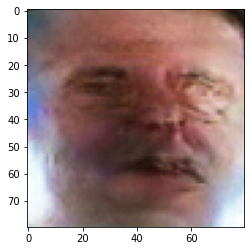

In [547]:
pyplot.imshow(vector_image[0])

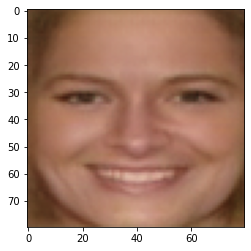

In [548]:
pyplot.imshow(vector2_image[0])

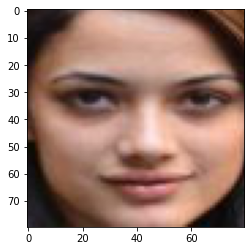

In [664]:
a,b,c,d =generate_samples(dataset,labels,1)
pyplot.imshow((b[0]+1)/2)

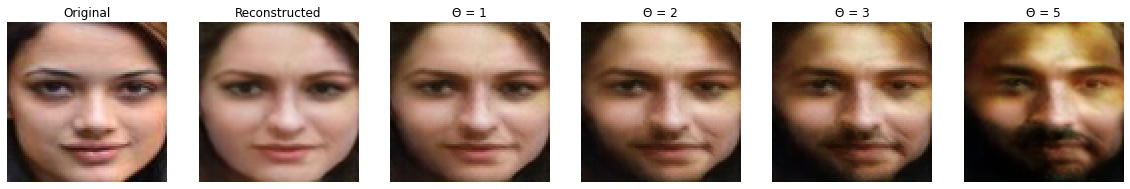

In [666]:
re = generator.predict(encoder.predict(b) )
ans0 = generator.predict(encoder.predict(b) -vector*.2)
ans1 = generator.predict(encoder.predict(b) -vector*.4)
ans2 = generator.predict(encoder.predict(b) -vector*.6)
ans3 = generator.predict(encoder.predict(b) -vector*1)
fig, axes = plt.subplots(1, 6)
axes[0].imshow((b[0]+1)/2)
axes[1].imshow((re[0]+1)/2)
axes[2].imshow((ans0[0]+1)/2)
axes[3].imshow((ans1[0]+1)/2)
axes[4].imshow((ans2[0]+1)/2)
axes[5].imshow((ans3[0]+1)/2)
for ax in axes:
    ax.set_axis_off()
axes[0].set_title('Original')
axes[1].set_title('Reconstructed')
axes[2].set_title('Θ = 1')
axes[3].set_title('Θ = 2')
axes[4].set_title('Θ = 3')
axes[5].set_title('Θ = 5')

fig.set_size_inches(20, 20)

